In [2]:
!pip install squarify
!pip install plotly
!pip install plotly-express
!pip install lightgbm
!pip install statsmodels

import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

#import xgboost
import lightgbm
import statsmodels
import fbprophet

#from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
age_details = pd.read_csv('data/AgeGroupDetails.csv')
india_covid_19 = pd.read_csv('data/covid_19_india.csv')
hospital_beds = pd.read_csv('data/HospitalBedsIndia.csv')
individual_details = pd.read_csv('data/IndividualDetails.csv')
ICMR_details = pd.read_csv('data/ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv('data/ICMRTestingLabs.csv')
state_testing = pd.read_csv('data/StatewiseTestingDetails.csv')
state_vaccine = pd.read_csv('data/covid_vaccine_statewise.csv')
population = pd.read_csv('data/population_india_census2011.csv')

world_population = pd.read_csv('data/population_by_country_2020.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])
ICMR_details['DateTime'] = pd.to_datetime(ICMR_details['DateTime'],dayfirst = True)
ICMR_details = ICMR_details.dropna(subset=['TotalSamplesTested', 'TotalPositiveCases'])

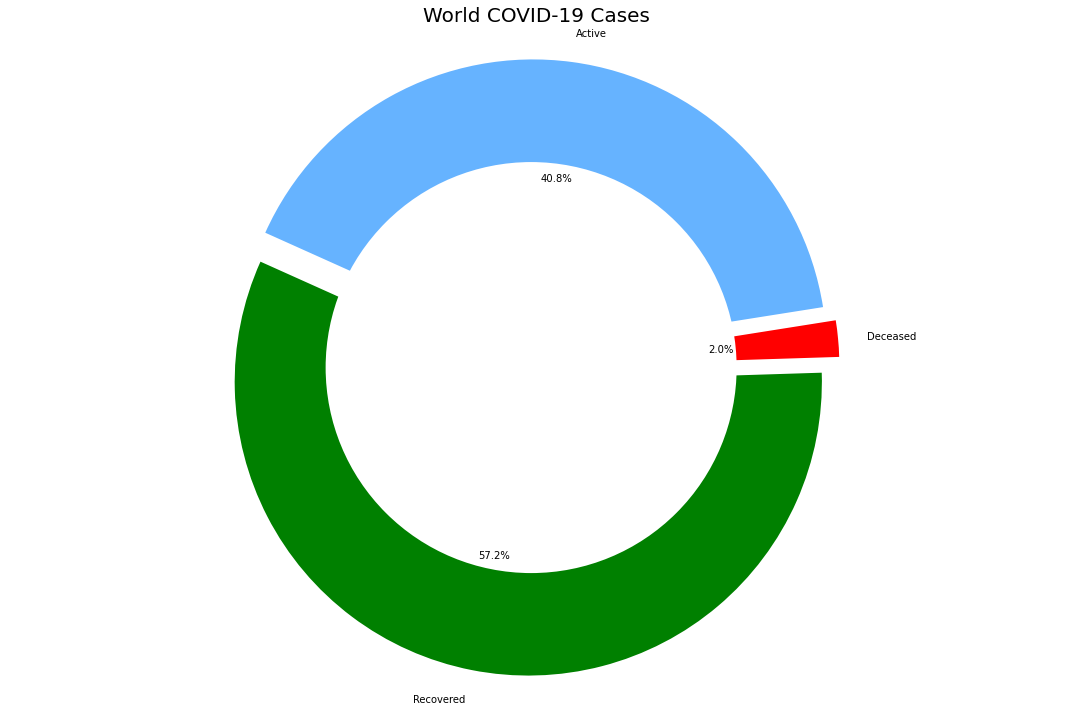

In [6]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
world_active = world_confirmed - (world_recovered - world_deaths)

labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

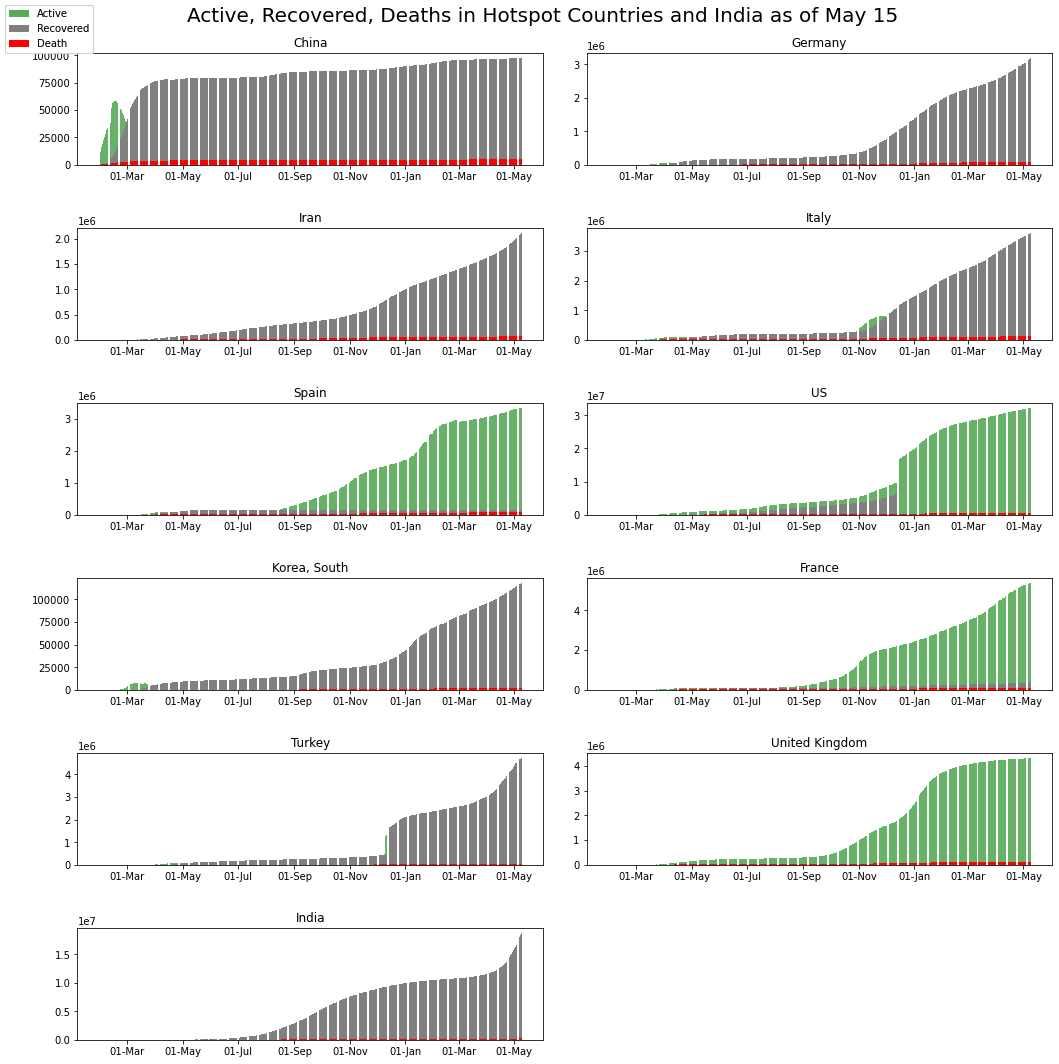

In [13]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of May 15',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,12):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)

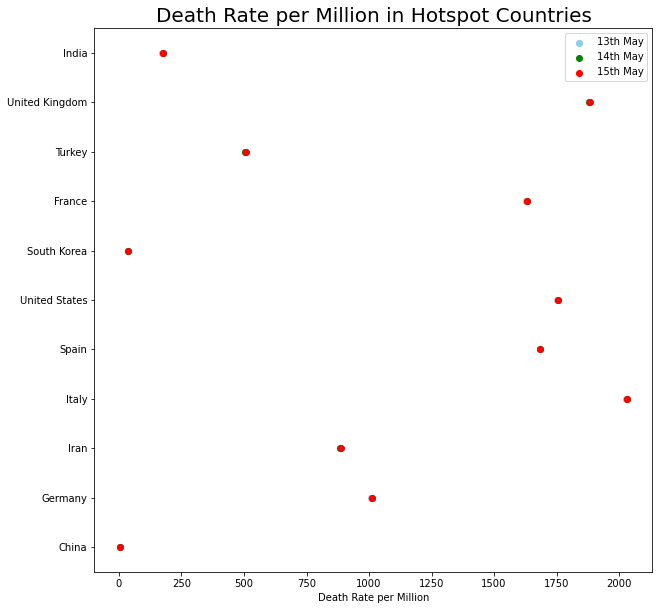

In [14]:
hotspots = ['China','Germany','Iran','Italy','Spain','United States','South Korea','France','Turkey','United Kingdom','India']
country_death_rate = pd.DataFrame(columns = ['country','day1','day2','day3'])
world_population['Population (2020)'] = world_population['Population (2020)']/1000000

d1=[]
d2 =[]
d3 = []
for country in hotspots:
    p = float(world_population[world_population['Country (or dependency)'] == country ]['Population (2020)'])
    if country == 'United States':
        k = global_deaths['US'][-3:]
    elif country == 'South Korea':
        k = global_deaths['Korea, South'][-3:]
    else:
        k = global_deaths[country][-3:]
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))

country_death_rate['country'] = hotspots
country_death_rate['day1'] = d1
country_death_rate['day2'] = d2
country_death_rate['day3'] = d3    

plt.figure(figsize= (10,10))
plt.hlines(y=country_death_rate['country'], xmin=country_death_rate['day1'], xmax=country_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(country_death_rate['day1'], country_death_rate['country'], color='skyblue', label='13th May');
plt.scatter(country_death_rate['day2'], country_death_rate['country'], color='green', label='14th May');
plt.scatter(country_death_rate['day3'], country_death_rate['country'], color='red', label='15th May');
plt.legend();
plt.title("Death Rate per Million in Hotspot Countries",fontsize=20);
plt.xlabel('Death Rate per Million');

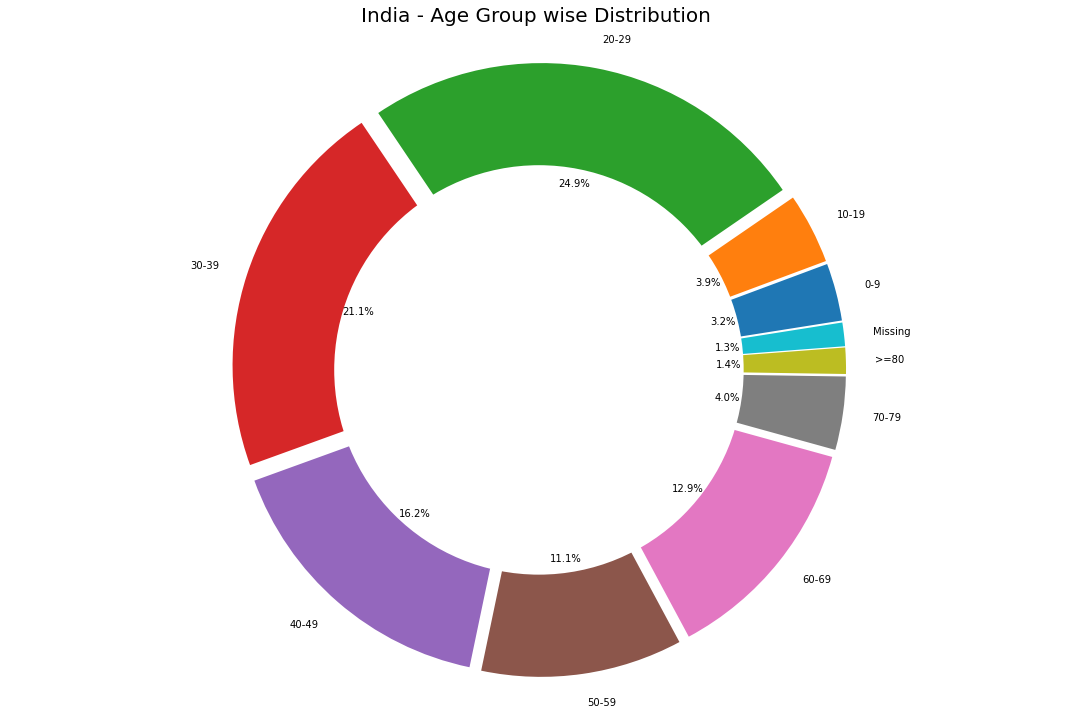

In [15]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()


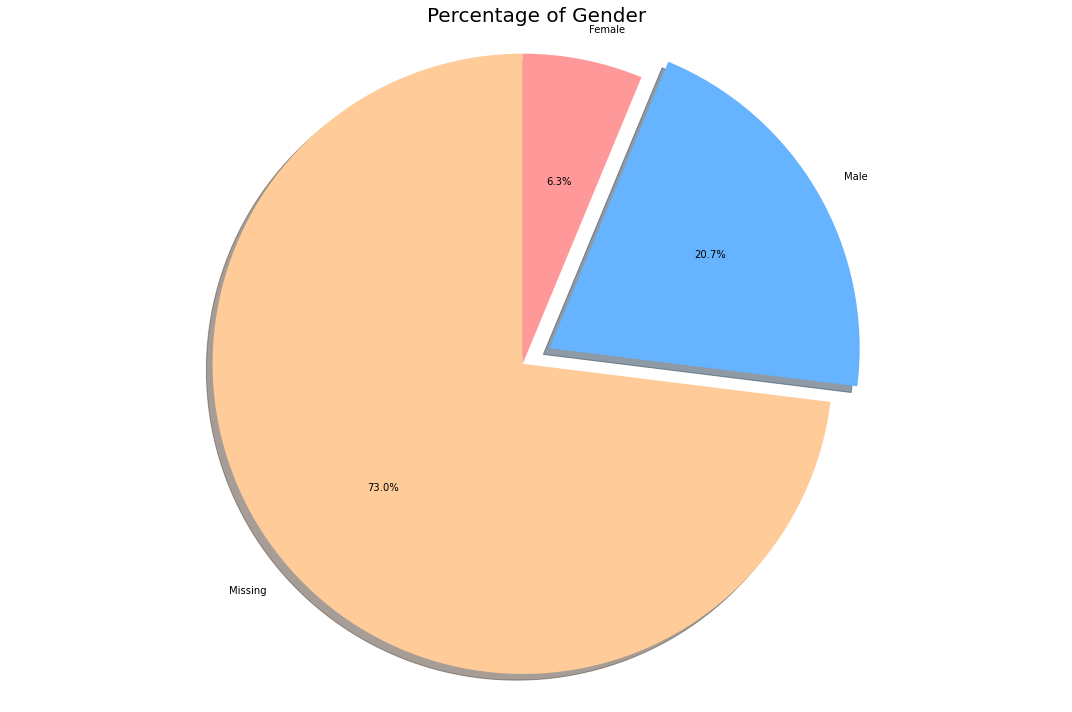

In [16]:
labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0, 0.1, 0)
colors = ['#ffcc99','#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.title('Percentage of Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.tight_layout()

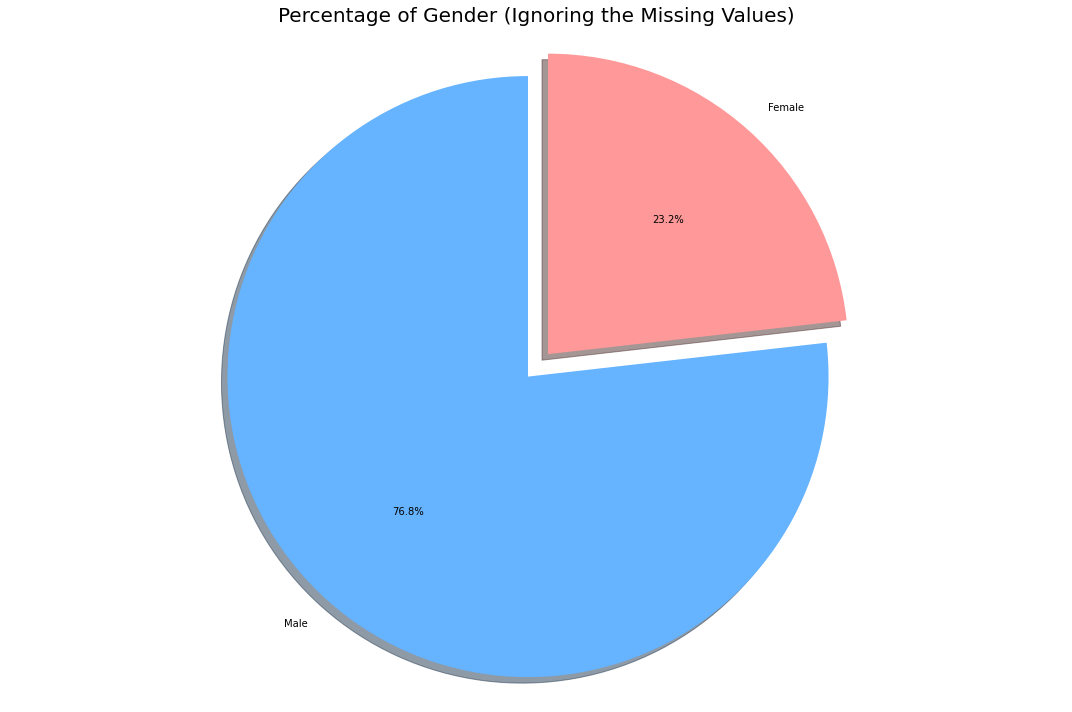

In [17]:
labels = ['Male', 'Female']
sizes = []
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Percentage of Gender (Ignoring the Missing Values)',fontsize = 20)
plt.axis('equal')
plt.tight_layout()

In [18]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

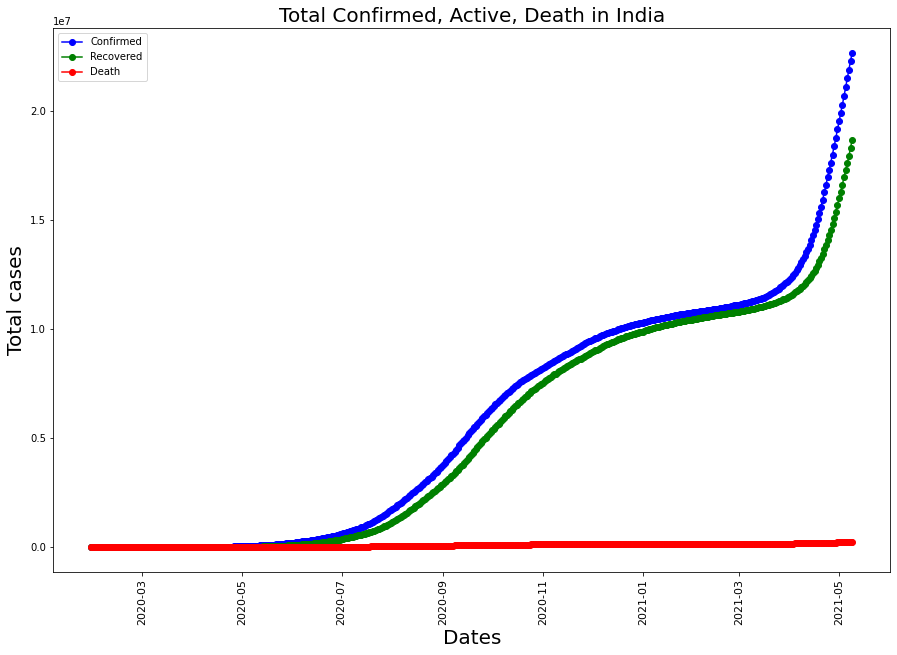

In [19]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

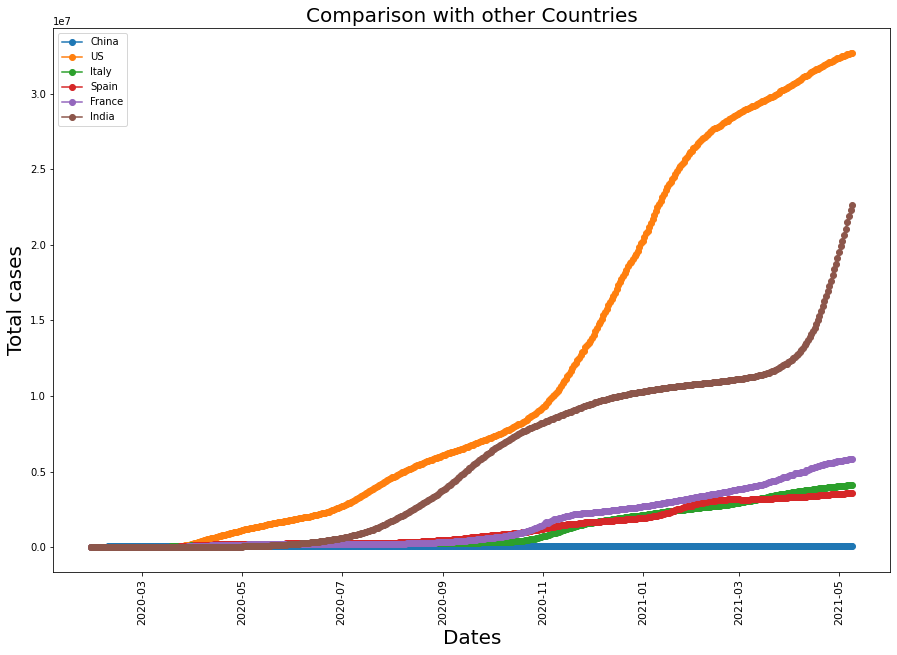

In [20]:
countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

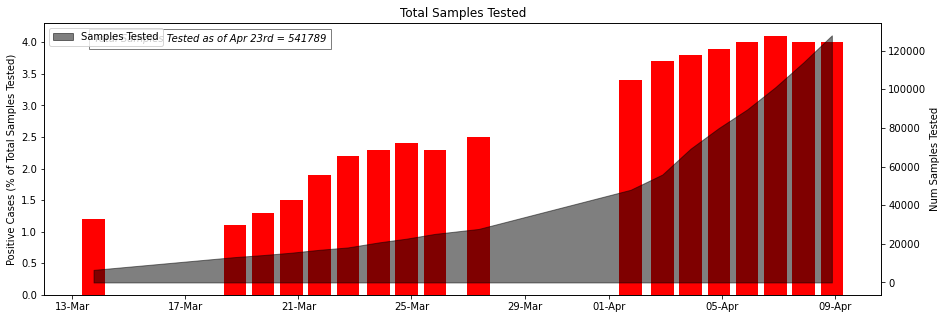

In [21]:
ICMR_details['Percent_positive'] = round((ICMR_details['TotalPositiveCases']/ICMR_details['TotalSamplesTested'])*100,1)

fig, ax1 = plt.subplots(figsize= (15,5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax1.set_ylabel('Positive Cases (% of Total Samples Tested)')
ax1.bar(ICMR_details['DateTime'] , ICMR_details['Percent_positive'], color="red",label = 'Percentage of Positive Cases')
ax1.text(ICMR_details['DateTime'][0],4, 'Total Samples Tested as of Apr 23rd = 541789', style='italic',fontsize= 10,
        bbox={'facecolor': 'white' ,'alpha': 0.5, 'pad': 5})

ax2 = ax1.twinx()  
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.set_ylabel('Num Samples Tested')
ax2.fill_between(ICMR_details['DateTime'],ICMR_details['TotalSamplesTested'],color = 'black',alpha = 0.5,label = 'Samples Tested');

plt.legend(loc="upper left")
plt.title('Total Samples Tested')
plt.show()

In [22]:
state_cases = india_covid_19.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()

#state_cases = state_cases.astype({'Deaths': 'int'})
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
22,Maharashtra,4996758,74413,4265326,657019,1.490000,85.360000
17,Karnataka,1838885,17804,1284420,536661,0.970000,69.850000
18,Kerala,1824856,5682,1416177,402997,0.310000,77.600000
37,Uttar Pradesh,1453679,14873,1184688,254118,1.020000,81.500000
32,Tamil Nadu,1323965,15171,1173439,135355,1.150000,88.630000
10,Delhi,1292867,18739,1183093,91035,1.450000,91.510000
1,Andhra Pradesh,1245374,8519,1050160,186695,0.680000,84.320000
39,West Bengal,954282,12076,818108,124098,1.270000,85.730000
7,Chhattisgarh,830117,10158,688918,131041,1.220000,82.990000
30,Rajasthan,720799,5346,516306,199147,0.740000,71.630000


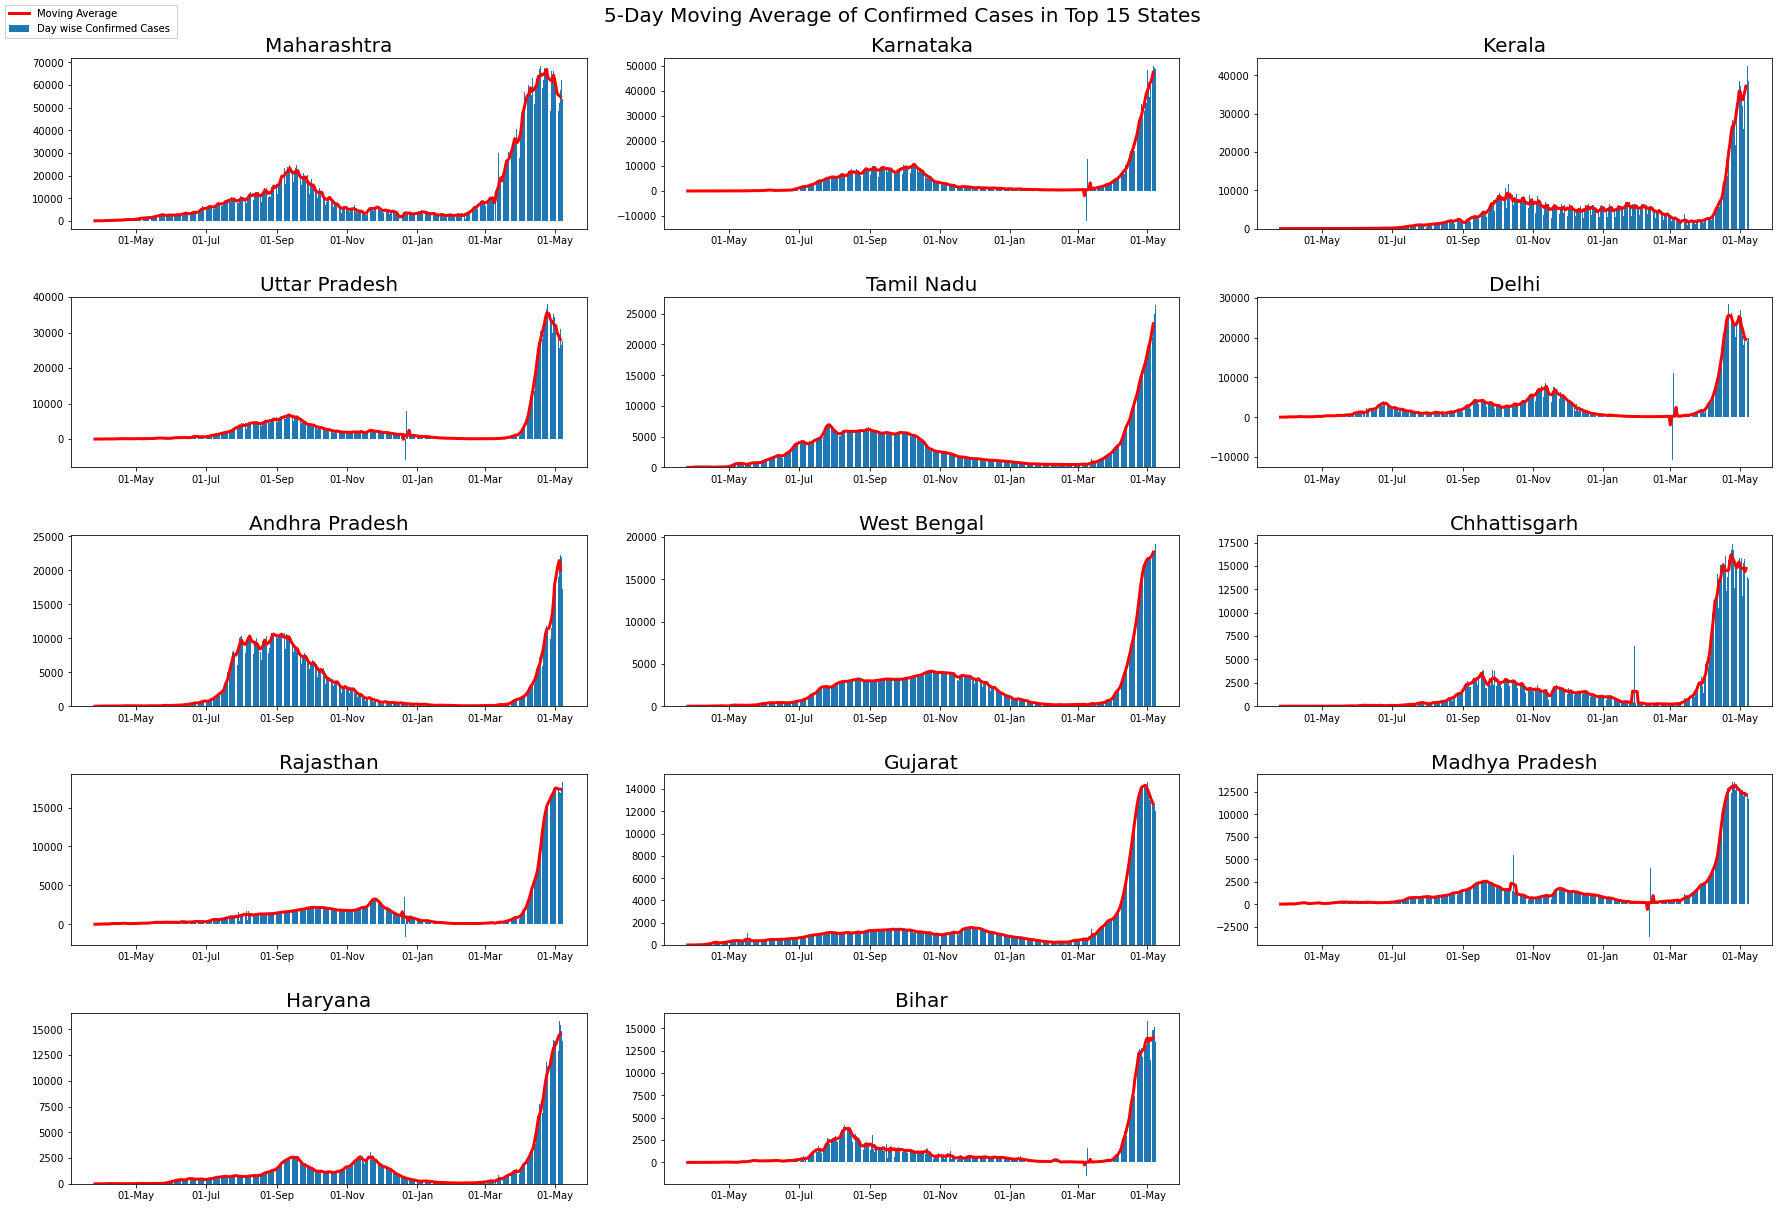

In [23]:
all_state = list(india_covid_19['State/UnionTerritory'].unique())
all_state.remove('Unassigned')
#all_state.remove('Nagaland#')
#all_state.remove('Nagaland')
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}

for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active'][i]-df['Active'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]
    
def calc_movingaverage(values ,N):    
    cumsum, moving_aves = [0], [0,0]
    for i, x in enumerate(values, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves

fig = plt.figure(figsize= (25,17))
plt.suptitle('5-Day Moving Average of Confirmed Cases in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    moving_aves = calc_movingaverage(states_confirmed[states[k]],5)
    ax.plot(states_dates[states[k]][:-2],moving_aves,color='red',label = 'Moving Average',linewidth =3)  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

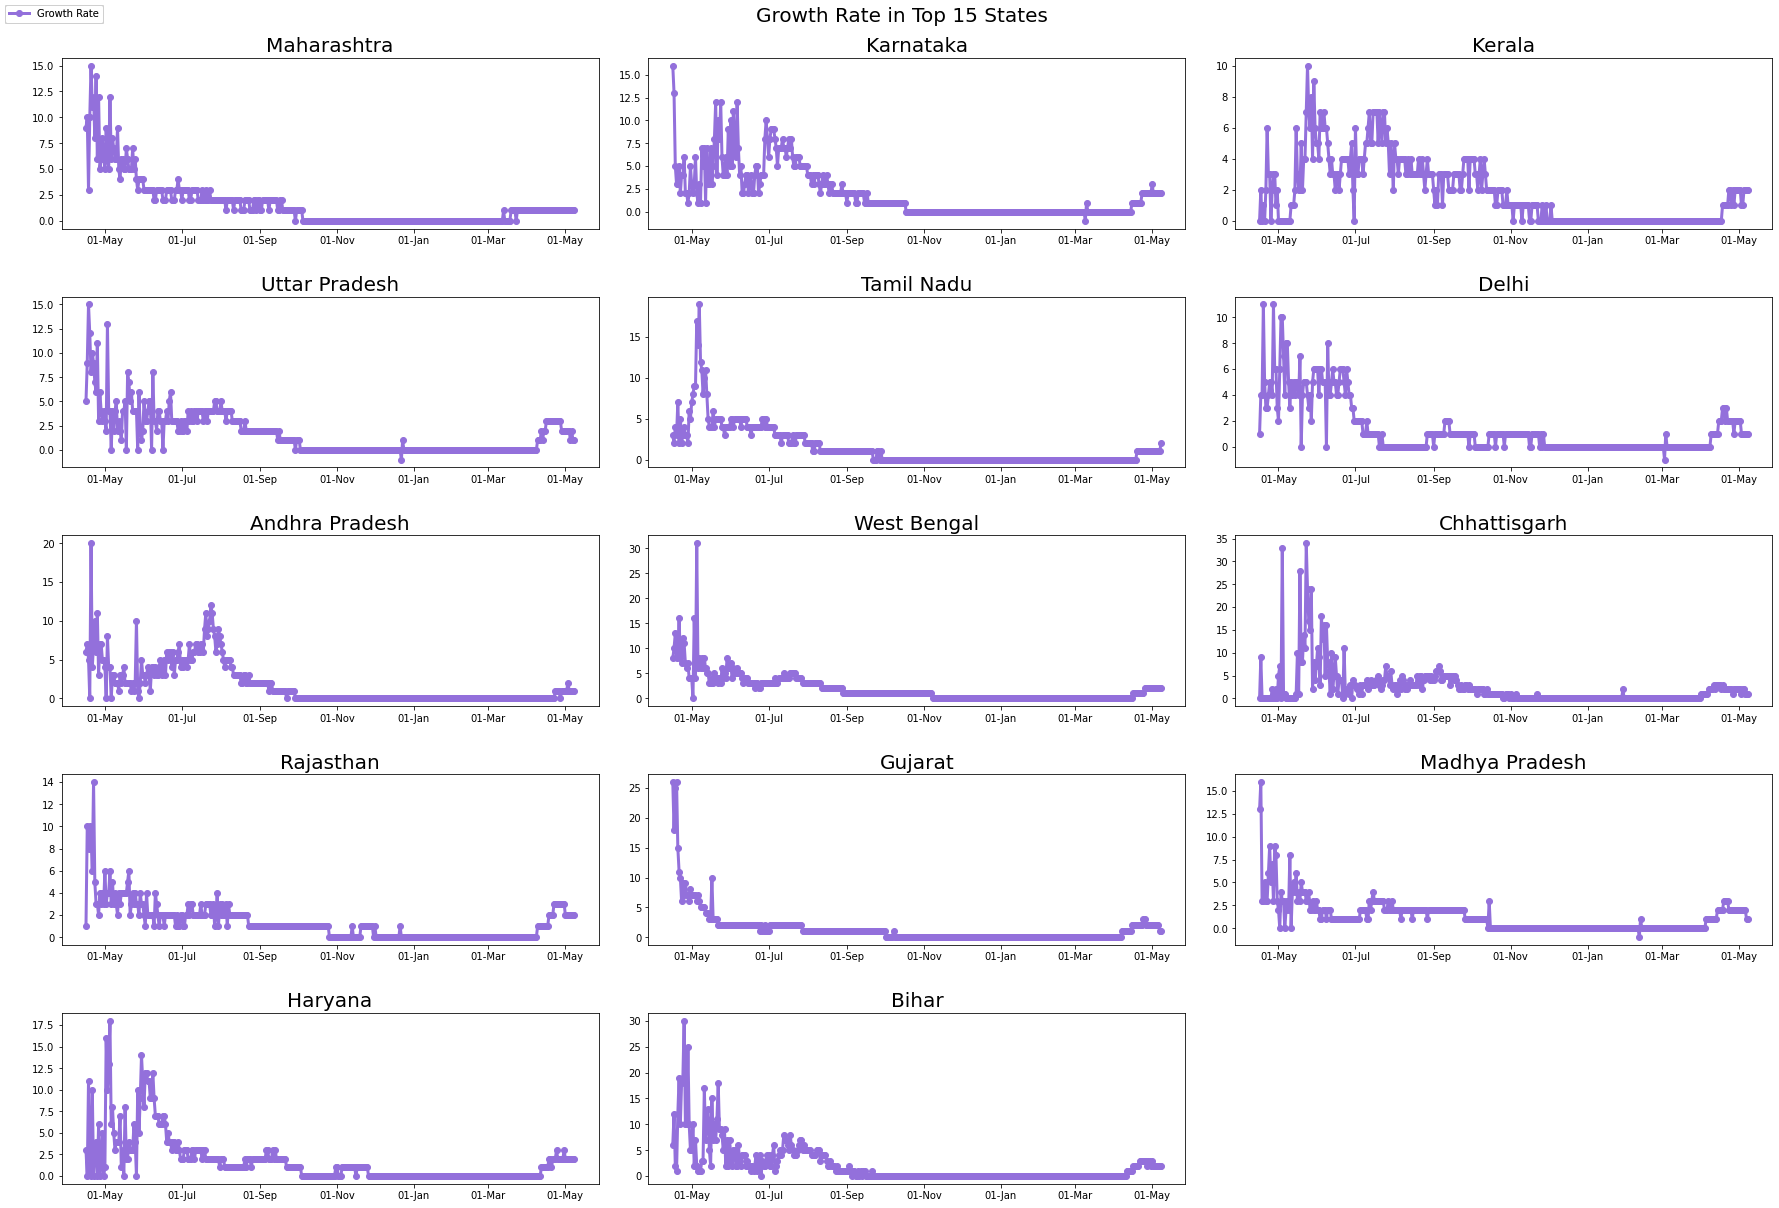

In [24]:
def calc_growthRate(values):
    k = []
    for i in range(1,len(values)):
        summ = 0
        for j in range(i):
            summ = summ + values[j]
        rate = (values[i]/summ)*100
        k.append(int(rate))
    return k

fig = plt.figure(figsize= (25,17))
plt.suptitle('Growth Rate in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    #ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    growth_rate = calc_growthRate(states_confirmed[states[k]])
    ax.plot_date(states_dates[states[k]][21:],growth_rate[20:],color = '#9370db',label = 'Growth Rate',linewidth =3,linestyle='-')  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

In [25]:
#norm = matplotlib.colors.Normalize(vmin=min(state_cases.Confirmed), vmax=max(state_cases.Confirmed))
#colors = [matplotlib.cm.Blues(norm(value)) for value in state_cases.Confirmed]

#plt.figure(figsize= (15,10))
#fig = plt.gcf()
#ax = fig.add_subplot()

#squarify.plot(label=list(state_cases.index),sizes=state_cases.Confirmed, color = colors, alpha=.6)

#plt.title("Statewise Distribution",fontsize=23,fontweight="bold")
#plt.axis('off')
#plt.show()

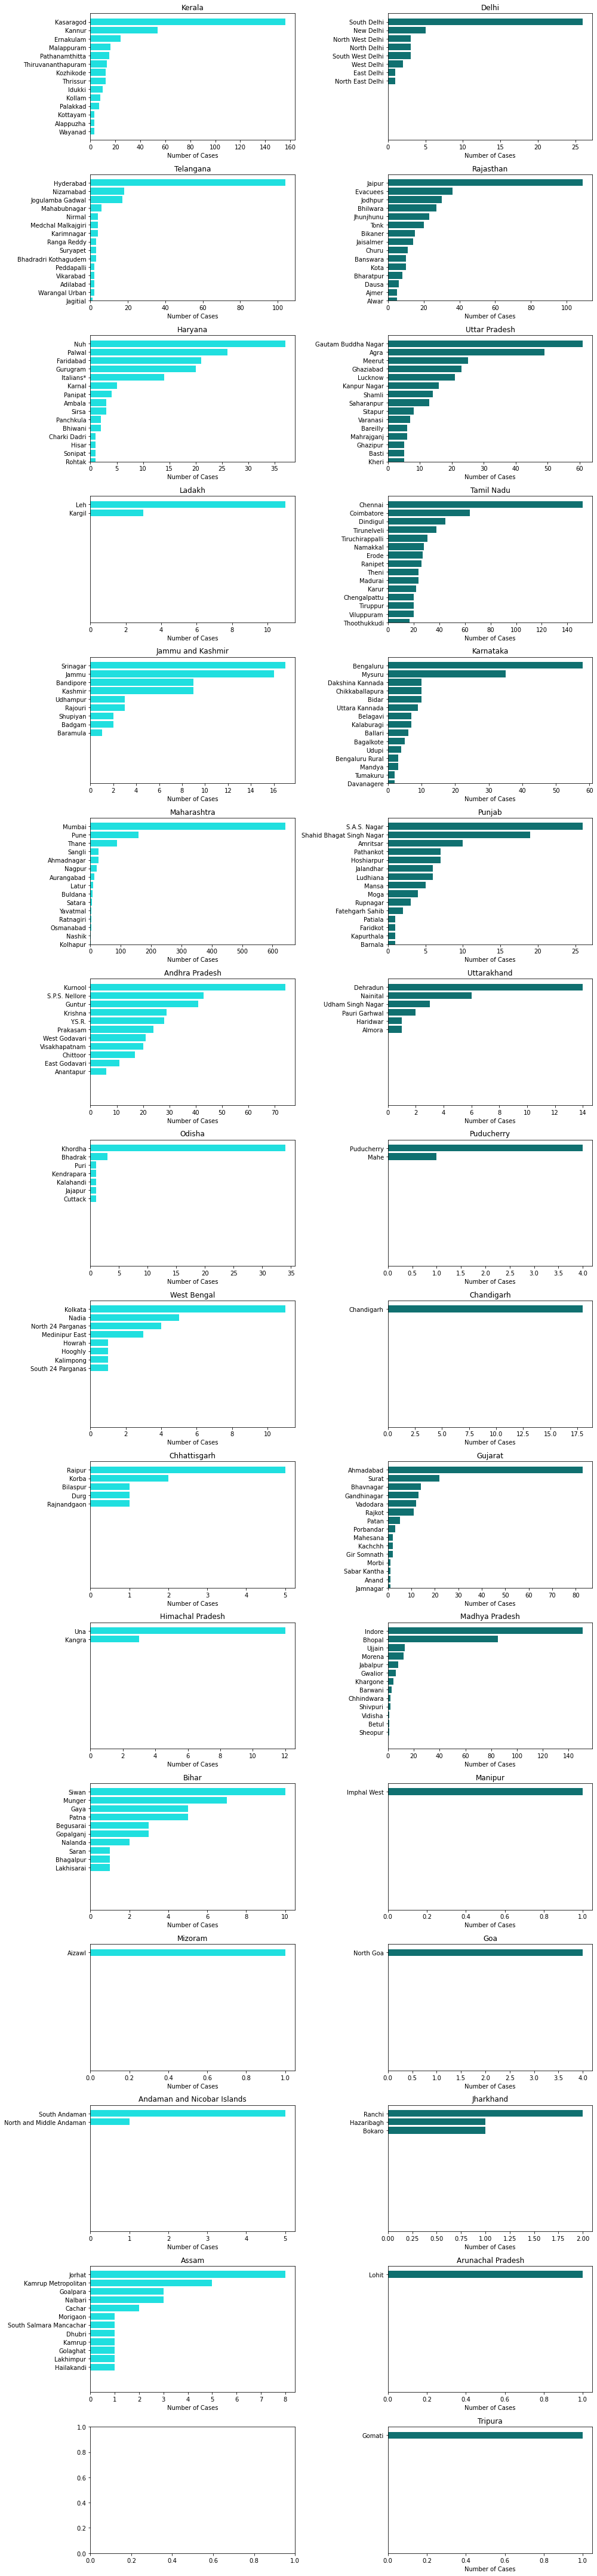

In [26]:
colors_list = ['cyan','teal']
states = individual_details['detected_state'].unique()
if len(states)%2==0:
    n_rows = int(len(states)/2)
else:
    n_rows = int((len(states)+1)/2)    
plt.figure(figsize=(14,60))

for idx,state in enumerate(states):    
    plt.subplot(n_rows,2,idx+1)
    y_order = individual_details[individual_details['detected_state']==state]['detected_district'].value_counts().index
    try:
        g = sns.countplot(data=individual_details[individual_details['detected_state']==state],y='detected_district',orient='v',color=colors_list[idx%2],order=y_order)
        plt.xlabel('Number of Cases')
        plt.ylabel('')
        plt.title(state)
        plt.ylim(14,-1)
    except:
        pass
plt.tight_layout()
plt.show()

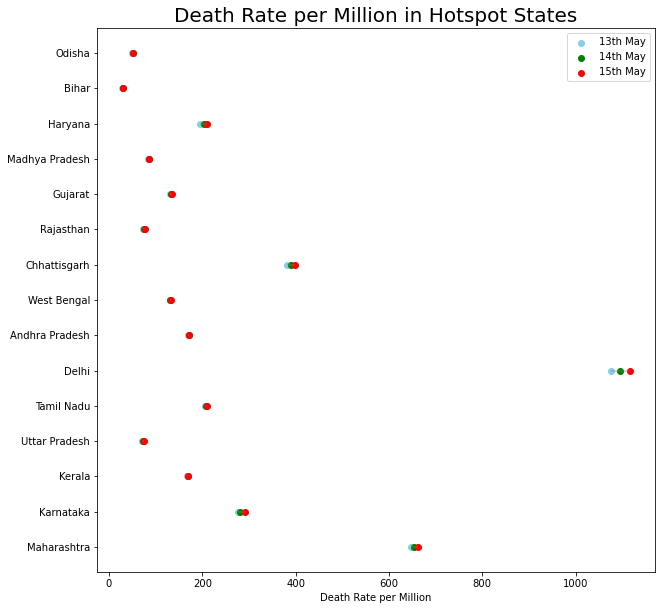

In [27]:
population['in_million'] = population['Population']/1000000
state_death_rate = pd.DataFrame(columns = ['state','day1','day2','day3'])
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

s = []
d1 = []
d2 = []
d3 = []

for state in states:
    k = list(india_covid_19[india_covid_19['State/UnionTerritory'] == state]['Deaths'].tail(3))
    p = float(population[population['State / Union Territory']== state]['in_million'])
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))
    s.append(state)
    
state_death_rate['state'] = s
state_death_rate['day1'] = d1
state_death_rate['day2'] = d2
state_death_rate['day3'] = d3

plt.figure(figsize= (10,10))
plt.hlines(y=state_death_rate['state'], xmin=state_death_rate['day1'], xmax=state_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(state_death_rate['day1'], state_death_rate['state'], color='skyblue', label='13th May');
plt.scatter(state_death_rate['day2'], state_death_rate['state'], color='green', label='14th May');
plt.scatter(state_death_rate['day3'], state_death_rate['state'], color='red', label='15th May');
plt.legend();
plt.title("Death Rate per Million in Hotspot States",fontsize=20);
plt.xlabel('Death Rate per Million');

In [28]:
hospital_beds =hospital_beds.drop([36])
cols_object = list(hospital_beds.columns[2:8])

for cols in cols_object:
    hospital_beds[cols] = hospital_beds[cols].astype(int,errors = 'ignore')

In [29]:
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')

plt.figure(figsize=(15,10))
plt.suptitle('Top 10 States in each Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Primary Health Centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color ='#87479d');

plt.subplot(222)
plt.title('Community Health Centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color = '#9370db');

plt.subplot(224)
plt.title('Total Public Health Facilities')
plt.barh(top_10_community['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#9370db');

plt.subplot(223)
plt.title('District Hospitals')
plt.barh(top_10_community['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color = '#87479d');

TypeError: Column 'NumPrimaryHealthCenters_HMIS' has dtype object, cannot use method 'nlargest' with this dtype

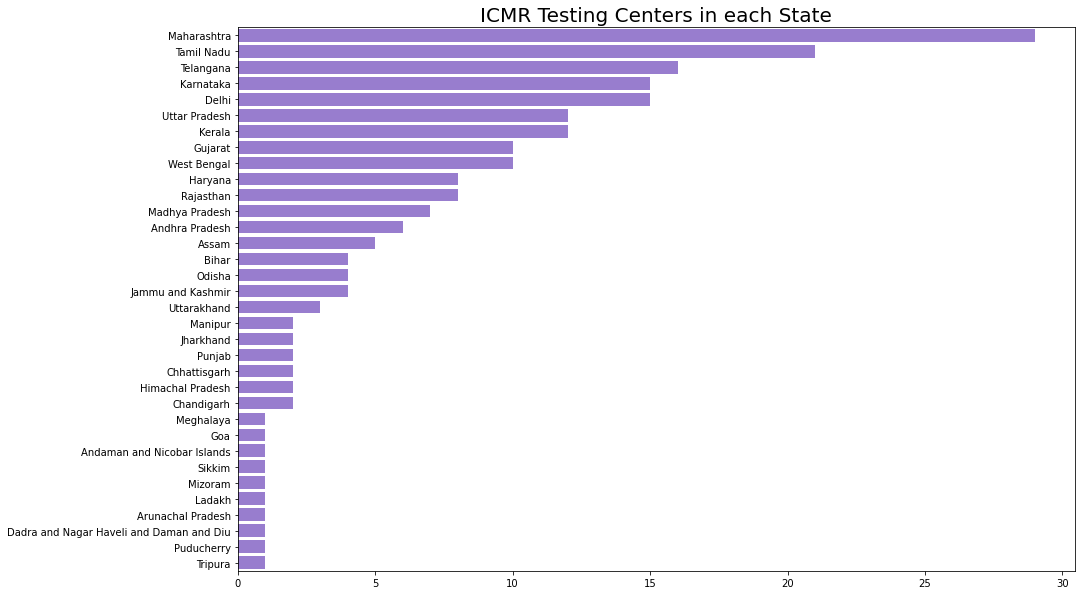

In [30]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
plt.title('ICMR Testing Centers in each State', fontsize = 20)
sns.barplot(x= values, y= names,color = '#9370db');


In [31]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/21':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.0079412714333924


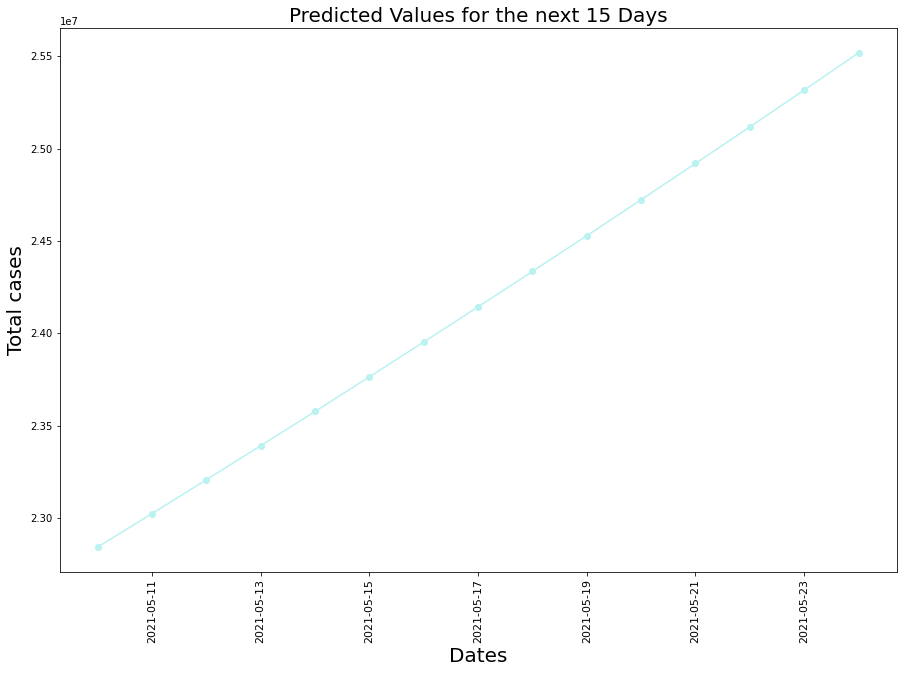

In [32]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(dates_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


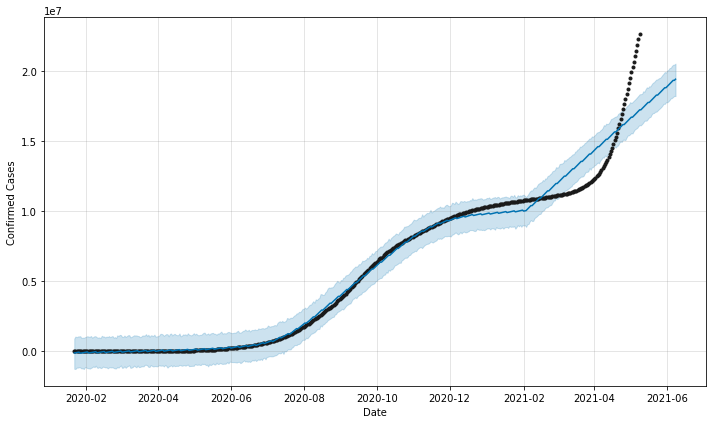

In [35]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

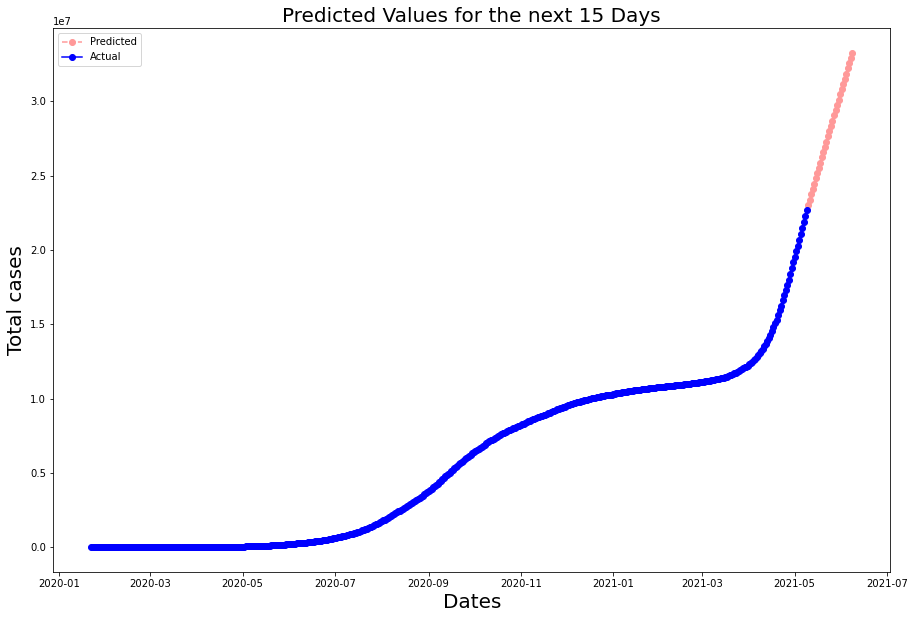

In [36]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();
